In [59]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [73]:
from proj1_helpers import *
from validation_helpers import *
from plots import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [72]:
from implementations import *

## Do your thing crazy machine learning thing here :) ...

In [4]:
split_x, split_y, split_ids = separate(y, tX, ids)

In [5]:
selection = dataStatistics(split_x)

Statistics 
Type :
0
[0.26145747 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.        ]
Statistics 
Type :
1
[0.09751883 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05859584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.0

In [6]:
cleaned = removeNone(split_x, selection)



# Now we can either drop the lines with residual Nones or replace the Nones by the median value

In [7]:
cleaned_with_median = putMedianInsteadOfNone(cleaned)

cleaned_with_median_with_momentum = add_momentum_vector(cleaned_with_median)

In [8]:
dropped_x, dropped_y, dropped_ids = dropLineIfNone(cleaned, split_y, split_ids)


## At this point, the first values in each of the split data has a PRI_jet_num = 0, then 1 and so on. The data is clean and we can work with it.

## Generate predictions and save ouput in csv format for submission:

In [9]:
DATA_TEST_PATH = '../data/test.csv' 
y_donotUse, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [85]:
#separate data with respect to column 24 and remove None
split_x_test, _, split_ids_test =  separate(y_donotUse, tX_test, ids_test)


split_x_cleaned_test = removeNone(split_x_test, dataStatistics(split_x_test))

#median instead of None
split_x_with_median = putMedianInsteadOfNone(split_x_cleaned_test)

split_x_with_median_with_momentum = add_momentum_vector(split_x_with_median)

#line dropped when None
#split_x_drop_lines, split_y_dropped_split_indexes_dropped = dropLineIfNone(split_x_cleaned_test, _, split_ids_test)

#degrees for polynomial feature expension
degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

y_res = []

acc = []

plot_data_per_jetnum = []


for i in range(len(cleaned_with_median)):
    
    
    
    #training: chose either cross calidation or cross validation for logistic regression with regularization
    #w_star, d, accuracy, training_set, plot_data = crossValidation(cleaned_with_median[i], split_y[i], 0.98, degrees ,6)
    w_star, d, accuracy, training_set, plot_data = crossValidationForLogistic_reg_with_loss(cleaned_with_median[i], split_y[i], 0.9, degrees ,6)
    
    
    #polynomial feature expension and normalization using the training data
    mean = np.mean(build_poly(training_set,d), axis = 0)
    std = np.std(build_poly(training_set,d), axis = 0)
    
      
    #put 1 if std = 0
    std = std + (std == 0)
    
    extended_and_normalized = (build_poly(split_x_with_median[i], d) - mean) / std
    
    #adding bias term
    bias = np.ones(shape=split_x_with_median[i].shape)          
    x_test_ready = np.c_[bias, extended_and_normalized]
    
    #prediction
    y_res.append(predict_labels(w_star, x_test_ready))


    acc.append(accuracy)
    plot_data_per_jetnum.append(plot_data)

print("Accuracy per jet nbr: \n")
print(acc)


Statistics 
Type :
0
[0.2605448 0.        0.        0.        1.        1.        1.
 0.        0.        0.        0.        0.        1.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        1.        1.        1.        1.
 1.        0.       ]
Statistics 
Type :
1
[0.09834149 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05881481 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.06376737 0.         0.     

lambda=0.00000,degree=16, gamma=0.01000, Training Loss=inf, Testing Loss=-15865473604873.879
lambda=0.00000,degree=16, gamma=0.21000, Training Loss=inf, Testing Loss=-333189315485158.44
lambda=0.00000,degree=16, gamma=0.41000, Training Loss=inf, Testing Loss=-650509373607479.9
lambda=0.00000,degree=16, gamma=0.61000, Training Loss=inf, Testing Loss=-967825637432562.6
lambda=0.00000,degree=16, gamma=0.81000, Training Loss=inf, Testing Loss=-1285138107004218.8
lambda=0.00100,degree=1, gamma=0.01000, Training Loss=-1192511717555509.0, Testing Loss=-14909970822238.396
lambda=0.00100,degree=1, gamma=0.21000, Training Loss=-2.4890919577183064e+16, Testing Loss=-311209071238239.9
lambda=0.00100,degree=1, gamma=0.41000, Training Loss=-4.829939159885889e+16, Testing Loss=-603879640435525.6
lambda=0.00100,degree=1, gamma=0.61000, Training Loss=-7.1421343397256136e+16, Testing Loss=-892964507639041.9
lambda=0.00100,degree=1, gamma=0.81000, Training Loss=-9.42601518780549e+16, Testing Loss=-117850

lambda=0.00200,degree=1, gamma=0.61000, Training Loss=-7.0105552766746056e+16, Testing Loss=-876498207454718.2
lambda=0.00200,degree=1, gamma=0.81000, Training Loss=-9.196726528234101e+16, Testing Loss=-1149812602230823.2
lambda=0.00200,degree=2, gamma=0.01000, Training Loss=inf, Testing Loss=-15457682001465.318
lambda=0.00200,degree=2, gamma=0.21000, Training Loss=inf, Testing Loss=-320675465412862.1
lambda=0.00200,degree=2, gamma=0.41000, Training Loss=inf, Testing Loss=-618479309695488.6
lambda=0.00200,degree=2, gamma=0.61000, Training Loss=inf, Testing Loss=-909042797524371.2
lambda=0.00200,degree=2, gamma=0.81000, Training Loss=inf, Testing Loss=-1192535870266413.2
lambda=0.00200,degree=3, gamma=0.01000, Training Loss=inf, Testing Loss=-15626769233822.684
lambda=0.00200,degree=3, gamma=0.21000, Training Loss=inf, Testing Loss=-324190168870341.2
lambda=0.00200,degree=3, gamma=0.41000, Training Loss=inf, Testing Loss=-625270879149097.2
lambda=0.00200,degree=3, gamma=0.61000, Trainin

lambda=0.00000,degree=4, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=4, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=4, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=4, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=4, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=5, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=5, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=5, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=5, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=5, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=6, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=6, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=6, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.000

lambda=0.00100,degree=9, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=9, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=10, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=10, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=10, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=10, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=10, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=11, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=11, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=11, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=11, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=11, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=12, gamma=0.01000, Training Loss=inf, Testing Loss=inf
l

lambda=0.00200,degree=15, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=15, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=15, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=15, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=16, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=16, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=16, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=16, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=16, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=1, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=1, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=1, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=1, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lam

lambda=0.00100,degree=4, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=5, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=5, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=5, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=5, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=5, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=6, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=6, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=6, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=6, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=6, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=7, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=7, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.001

lambda=0.00200,degree=10, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=10, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=10, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=11, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=11, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=11, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=11, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=11, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=12, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=12, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=12, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=12, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=12, gamma=0.81000, Training Loss=inf, Testing Loss=inf

lambda=0.00000,degree=15, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=15, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=15, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=15, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=15, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=16, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=16, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=16, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=16, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00000,degree=16, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00100,degree=1, gamma=0.01000, Training Loss=-12141416032024.709, Testing Loss=-166385016287.0017
lambda=0.00100,degree=1, gamma=0.21000, Training Loss=-253471880888826.38, Testing Loss=-3473489401665.647
lambda=0.00100,d

lambda=0.00200,degree=3, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=3, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=3, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=3, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=3, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=4, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=4, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=4, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=4, gamma=0.61000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=4, gamma=0.81000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=5, gamma=0.01000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=5, gamma=0.21000, Training Loss=inf, Testing Loss=inf
lambda=0.00200,degree=5, gamma=0.41000, Training Loss=inf, Testing Loss=inf
lambda=0.002

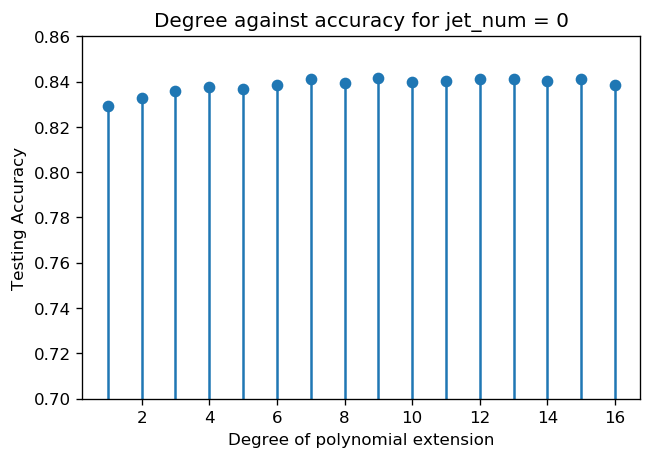

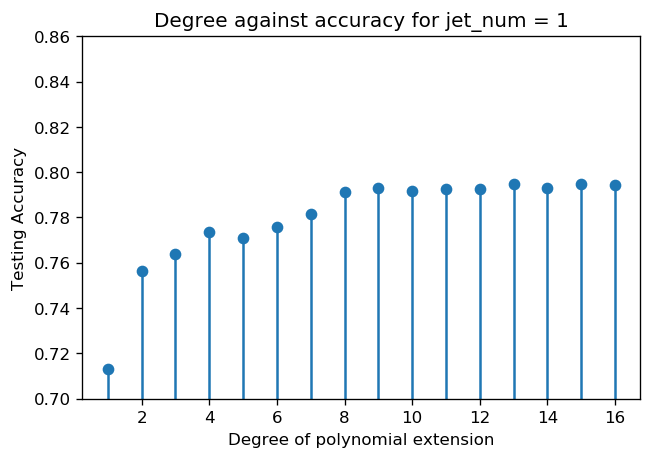

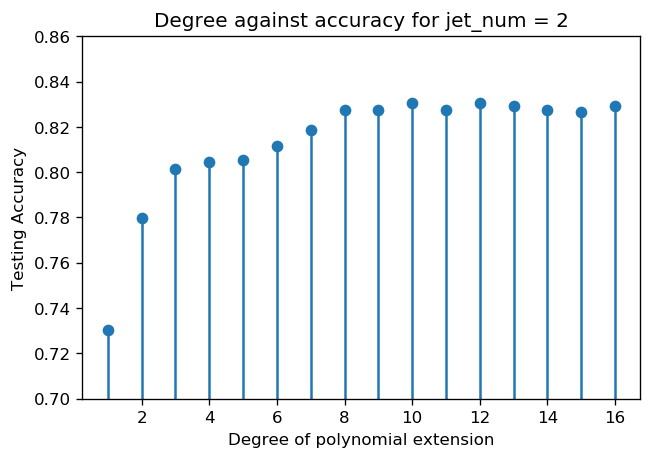

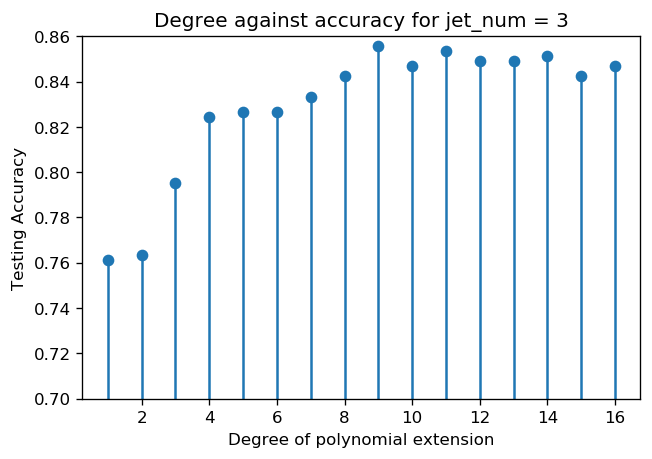

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for i in range(len(plot_data_per_jetnum)):
    jet_num = plot_data_per_jetnum[i]



    X = np.array([x[0] for x in jet_num])
    Y = np.array([x[1] for x in jet_num])
    Z = np.array([x[3] for x in jet_num])
    

    plt.figure(dpi=120)
    plt.title('Degree against accuracy for jet_num = %d' %i)
    plt.xlabel('Degree of polynomial extension')
    plt.ylabel('Testing Accuracy')

    axes = plt.gca()
    axes.set_ylim([0.7,0.86])

    plt.stem(Y, Z, use_line_collection=True, label="hello")
    plt.savefig("cross_with_momentum_"+str(i))
    plt.show()


In [84]:
OUTPUT_PATH = '../data/submission.csv'
#reassemble the data for the submission
y_pred = put_together(y_res, split_ids_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)